<a href="https://colab.research.google.com/github/TienLungSun/LLM/blob/main/MO%20detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

結合 video processing 與 image caption 進行 MO 監測

In [1]:
pip install einops torchvision

In [2]:
from transformers import AutoModelForCausalLM, AutoProcessor, GenerationConfig
from PIL import Image
import requests

In [3]:
# load the processor
processor = AutoProcessor.from_pretrained(
    'allenai/Molmo-7B-D-0924',
    trust_remote_code=True,
    torch_dtype='auto',
    device_map='auto'
)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


processor_config.json:   0%|          | 0.00/121 [00:00<?, ?B/s]

preprocessing_molmo.py:   0%|          | 0.00/6.43k [00:00<?, ?B/s]

image_preprocessing_molmo.py:   0%|          | 0.00/22.2k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/allenai/Molmo-7B-D-0924:
- image_preprocessing_molmo.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.
A new version of the following files was downloaded from https://huggingface.co/allenai/Molmo-7B-D-0924:
- preprocessing_molmo.py
- image_preprocessing_molmo.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


preprocessor_config.json:   0%|          | 0.00/634 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/92.2k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/2.78M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/1.67M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/7.11M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/14.3k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/12.0k [00:00<?, ?B/s]

In [4]:
# load the model
model = AutoModelForCausalLM.from_pretrained(
    'allenai/Molmo-7B-D-0924',
    trust_remote_code=True,
    torch_dtype='auto',
    device_map='auto'
)

config.json:   0%|          | 0.00/806 [00:00<?, ?B/s]

config_molmo.py:   0%|          | 0.00/1.98k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/allenai/Molmo-7B-D-0924:
- config_molmo.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


modeling_molmo.py:   0%|          | 0.00/95.4k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/allenai/Molmo-7B-D-0924:
- modeling_molmo.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


model.safetensors.index.json:   0%|          | 0.00/62.6k [00:00<?, ?B/s]

model-00001-of-00007.safetensors:   0%|          | 0.00/4.98G [00:00<?, ?B/s]

model-00002-of-00007.safetensors:   0%|          | 0.00/4.98G [00:00<?, ?B/s]

model-00003-of-00007.safetensors:   0%|          | 0.00/4.73G [00:00<?, ?B/s]

model-00004-of-00007.safetensors:   0%|          | 0.00/4.66G [00:00<?, ?B/s]

model-00005-of-00007.safetensors:   0%|          | 0.00/4.66G [00:00<?, ?B/s]

model-00006-of-00007.safetensors:   0%|          | 0.00/4.27G [00:00<?, ?B/s]

model-00007-of-00007.safetensors:   0%|          | 0.00/3.80G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/7 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/69.0 [00:00<?, ?B/s]

In [8]:
import cv2
from google.colab.patches import cv2_imshow
from PIL import Image
import numpy as np
from IPython.display import clear_output
import time

In [10]:
def process_frame(frame):
  # 處理影像和文字
  inputs = processor.process(
      images=[frame],
      text="Is this person passing through the gate in a normal way? Just answer YES or NO"
  )

  # move inputs to the correct device and make a batch of size 1
  inputs = {k: v.to(model.device).unsqueeze(0) for k, v in inputs.items()}

  # generate output; maximum 50 new tokens; stop generation when <|endoftext|> is generated
  output = model.generate_from_batch(
    inputs,
    GenerationConfig(max_new_tokens=50, stop_strings="<|endoftext|>"),
    tokenizer=processor.tokenizer
  )

  # only get generated tokens; decode them to text
  generated_tokens = output[0,inputs['input_ids'].size(1):]
  generated_text = processor.tokenizer.decode(generated_tokens, skip_special_tokens=True)

  # return the generated text
  return generated_text

In [7]:
# 定義將9張縮小的圖片拼接成3x3大圖的函數
def form_large_img(frameLst):
    # 確保傳入的圖片數量為9
    if len(frameLst) != 9:
        raise ValueError("圖片數量必須是9張")

    # 取得圖片的寬和高（假設所有圖片大小相同）
    width, height = frameLst[0].size

    # 設定拼接後大圖的寬和高
    new_width = width * 3
    new_height = height * 3

    # 建立空白的大圖
    new_img = Image.new('RGB', (new_width, new_height))

    # 將每張圖片按照 3x3 排列貼上去
    for i, img in enumerate(frameLst):
        x = (i % 3) * width
        y = (i // 3) * height
        new_img.paste(img, (x, y))

    return new_img

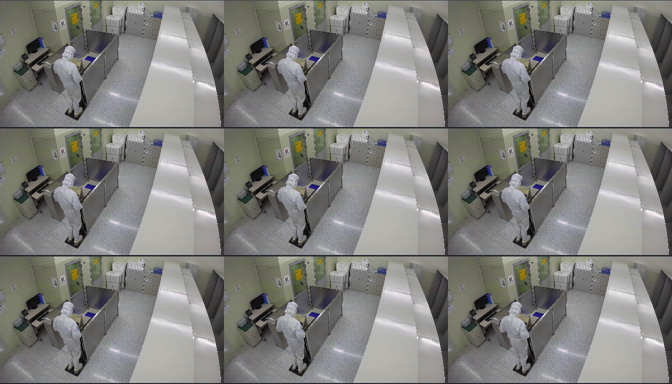

Frame 52  正常通過閘門嗎?   NO


KeyboardInterrupt: 

In [23]:
# 設定要讀取的視頻文件路徑
video_path = "entrance.mp4"  #entrance_mo.mp4

# 使用 OpenCV 讀取視頻
cap = cv2.VideoCapture(video_path)

# 檢查是否成功打開視頻文件
if not cap.isOpened():
    print("無法開啟視頻文件")
else:
    frameNo = 0
    frameLst = []
    while cap.isOpened():
        # 逐幀讀取視頻
        ret, frame = cap.read()
        frameNo += 1

        # 如果成功讀取到幀
        if not ret:
            break
        else:
            # 將每張圖片縮小1/3
            resized_frame = cv2.resize(frame, (0, 0), fx=1/3, fy=1/3)

            # 將BGR轉換為RGB格式
            frame_rgb = cv2.cvtColor(resized_frame, cv2.COLOR_BGR2RGB)
            # 將NumPy陣列轉為Pillow的Image對象
            image = Image.fromarray(frame_rgb)

            # 將縮小後的圖片加入列表
            if frameNo <= 9:
              frameLst.append(image)
            else:
              frameLst.pop(0)
              frameLst.append(image)

              # 將9張縮小的圖片拼接成3x3大圖
              large_img = form_large_img(frameLst)

              # 將拼接後的大圖再縮小以方便顯示
              large_img_resized = large_img.resize((large_img.width//2, large_img.height//2))

              # 將Pillow Image轉換回NumPy陣列以便顯示
              large_img_np = np.array(large_img_resized)

              # 將RGB格式轉換回BGR以便用OpenCV顯示
              large_img_bgr = cv2.cvtColor(large_img_np, cv2.COLOR_RGB2BGR)

              # 清除先前顯示的幀
              clear_output(wait=True)

              # 使用cv2_imshow來顯示縮小後的大圖
              cv2_imshow(large_img_bgr)

              generated_text = process_frame(large_img)

              # 打印格式化後的文本
              print("Frame", str(frameNo), " 正常通過閘門嗎? ", generated_text)

              # 控制播放速度 (例如每秒25幀)
              time.sleep(0.5)  # 0.04 秒大約等於 25 fps

# 釋放視頻對象
cap.release()

# 關閉所有窗口
cv2.destroyAllWindows()

In [ ]:
|